<p>
This project was created by leveraging the code provided by [Matterport, Inc.](https://github.com/matterport/Mask_RCNN). The structure of this project was copied from Matterport's [demo Jupyter Notebook](https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb). They also give a great explanation of how instance segmentation works in this [tutorial](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).
</p>

<p>
This YouTube [video](https://www.youtube.com/watch?v=2TikTv6PWDw) by Mark Jay was very helpful in explaining how to install all the necessary packages.   
</p>

In [4]:
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
import mrcnn.model as modellib
import numpy as np
import os
import random
import skimage.io
import sys
import time

from mrcnn import coco
from mrcnn import utils
from mrcnn import visualize

%matplotlib inline

#"mask_rcnn_coco.h5"

### Override the default config settings

In [5]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

### Create Model and Load Trained Weights
#### mask_rcnn_coco.h5 is not saved on my GitHub due to the large file size restriction. You can download it [here](https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5). After downloading it, move the file to the same folder as this Jupyter Notebook.

In [9]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode='inference', model_dir='', config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)

### Class Names

In [10]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### Run Instance Segmentation

In [74]:
img_names = ['background.jpg', 'cup.jpg', 'glasses_book.jpg', 'glasses.jpg', 'horse.jpg']
#img = skimage.io.imread('images/{}'.format(img_names[2]))
img = cv2.imread('images/{}'.format(img_names[2]))

total time (seconds) 16.533881187438965


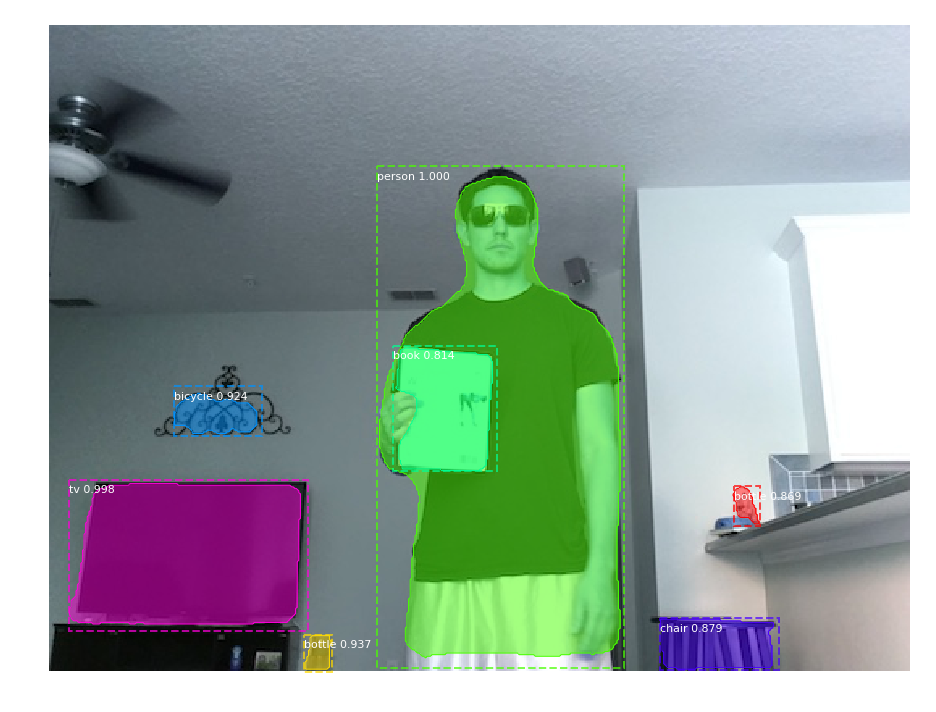

In [75]:
# Run detection
start = time.time()
results = model.detect([img], verbose=0)

end = time.time()
print('total time (seconds)', end - start)

# Visualize results
results = results[0]
visualize.display_instances(img, results['rois'], results['masks'], results['class_ids'], 
                            class_names, results['scores'])

In [82]:
# shape of the masks are (h, w, object_ix)

n_objects_found = len(results['class_ids'])
for ix in range(n_objects_found):
    if results['class_ids'][ix] == class_names.index('person'):
        print('person', ix)
        mask = results['masks'][:, :, ix]
        other_masks = np.delete(results['masks'], mask, axis=2)
        print(other_masks.shape)
        other_masks_merged = np.logical_or.reduce(other_masks, axis=2)
        print(other_masks_merged.shape)
        
        img_copy = np.copy(img)
        img_copy[mask & np.logical_not(other_masks_merged)] = [0, 255, 0]
        cv2.imwrite('test.png', img_copy)

person 0
(400, 533, 5)
(400, 533)


/anaconda3/envs/newest/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer
  
